## TP3: Introducción al aprendizaje automático

In [129]:
import pandas as pd

In [130]:
Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2020_Mentoria_LluviasExtremas/master/dataset/datos_diarios_cordoba.csv", parse_dates = True, index_col="fecha")
id_Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2020_Mentoria_LluviasExtremas/master/dataset/metadatos_estaciones.csv")

De los datasets analizados en los TPs anteriores, ahora nos vamos a enfocar en:

- La Florida
- Marcos Juarez

Y vamos a usar como variable que queremos predecir, la PMDA que han calculado para cada año hidrológico (del 1/julio al 30/junio).

Las demás variables (como viento, temperatura, etc) las vamos a resumir para cada año hidrológico en la media (se pueden agregar más estadísticos pero así es suficiente).

##### Actividades:

##### OBJETIVO: Predecir Precipitación Máxima Diaria Anual (PMDA) para los próximos 5 años

1) De los dataset que han trabajado hasta ahora, agreguen más features al DataFrame **"Datos"** (Por lo general, más features tienden a dar mejores predicciones).

2) Además de las features del punto anterior, les propongo agregar nuevas features moviendo las originales tantos "pasos de tiempo" como features nuevas quieran generar.

3) Curar el dataset (si fuera necesario).

4) Aplicar técnicas de selección y extraccion de features. Armar un nuevo dataset con aquellas features más significativas.

5) Dividir el dataset (training, validation, test).. Recuerden que queremos predecir la PMDA para los próximos 5 años.

6) Analizar y elegir 3 modelos para REGRESIÓN. Entrenarlos y analizar resultados.

7) Evaluar predicciones de los diferentes modelos.

8) ¿Qué estadísticos utilizaron para evaluar las regresiones? Justifiquen su elección.

In [131]:
full_dataset = pd.read_csv('./datasetTP2/datos_diarios_cordoba_terra_chirps.csv')

In [158]:
dataset = full_dataset[(full_dataset['nombre'] == 'La Florida') | (full_dataset['nombre'] == 'Marcos Juarez INTA')]
dataset.loc[:, 'fecha'] = pd.to_datetime(dataset['fecha'])
dataset.reset_index(inplace=True)
dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [159]:
def get_hydro_year(date_, start_month=7):
    year = date_.strftime('%Y')
    month = date_.strftime('%m')
    offset = 1 if int(month) >= start_month - 1 else 0
    hydro_year = int(year) + offset - 1
    return hydro_year

def add_hydro_year(dataset):
    dataset = dataset.copy()
    dataset.reset_index(inplace=True)
    dataset['hydro_year'] = dataset['fecha'].apply(get_hydro_year)
    return dataset

def remove_cols(dataset, cols=['level_0', 'ano', 'mes', 'caudal', 'tmed', 'vmax_d', 'vmax_f']):
    return dataset.drop(cols, axis=1)

def get_grouped_dataset(dataset, group=['omm_id', 'hydro_year']):
    return dataset.groupby(group)

In [160]:
dataset = add_hydro_year(dataset)
dataset = remove_cols(dataset)

In [161]:
dataset.tail()

,index,fecha,omm_id,nombre,prcp,tmax,tmin,vmed,ETreal_mm,HumedadSuelo_mm,RadSolar_Wpm2,PresionVapor_hPa,IndicePalmer_porc,hydro_year
41353,84826,2018-11-24,1,La Florida,0.0,24.4,10.5,5.38,114.5,68.0,258.1,12.26,1.29,2018
41354,84827,2018-11-25,1,La Florida,0.0,24.4,10.5,5.38,114.5,68.0,258.1,12.26,1.29,2018
41355,84828,2018-11-26,1,La Florida,21.5,24.4,10.5,5.38,114.5,68.0,258.1,12.26,1.29,2018
41356,84829,2018-11-27,1,La Florida,94.0,24.4,10.5,5.38,114.5,68.0,258.1,12.26,1.29,2018
41357,84830,2018-11-28,1,La Florida,0.0,24.4,10.5,5.38,114.5,68.0,258.1,12.26,1.29,2018


In [162]:
# Aca no se si este es el camino a seguir, lo que tenemos que predecir es la PMDA, esa medida es el máximo anual, 
# pero el dataset que tenemos tiene datos diarios por lo que pense en agrupar las features por 'algo' para que 
# tuvieran sentido con PMDA ya que si no es asi, no me estoy dando cuenta como deberiamos separar en X e y.

In [163]:
pmda = get_grouped_dataset(dataset)['prcp'].max()
pmda.name = 'pmda'

In [164]:
humedad_suelo = get_grouped_dataset(dataset)['HumedadSuelo_mm'].mean()
humedad_suelo.name = 'humedad_suelo_mean'

In [165]:
tmax_mean = get_grouped_dataset(dataset)['tmax'].mean()
tmax_mean.name = 'tmax_mean'

In [166]:
prcp_mean = get_grouped_dataset(dataset)['prcp'].mean()
prcp_mean.name = 'prcp_mean'

In [167]:
presion_mean = get_grouped_dataset(dataset)['PresionVapor_hPa'].mean()
presion_mean.name = 'presion_mean'

In [172]:
features_dataset = pd.DataFrame(data=[humedad_suelo, tmax_mean, prcp_mean, presion_mean]).T.reset_index()

In [173]:
# Puse un par de features para ver que onda...

In [204]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np

In [189]:
features_columns = ['humedad_suelo_mean', 'tmax_mean', 'prcp_mean', 'presion_mean']
X = features_dataset[features_columns].copy()
y = pmda.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((91, 4), (23, 4))

In [180]:
# lo que sigue es un poco de fruta para ver a ojo si hay alguna relación entre las features y el target..

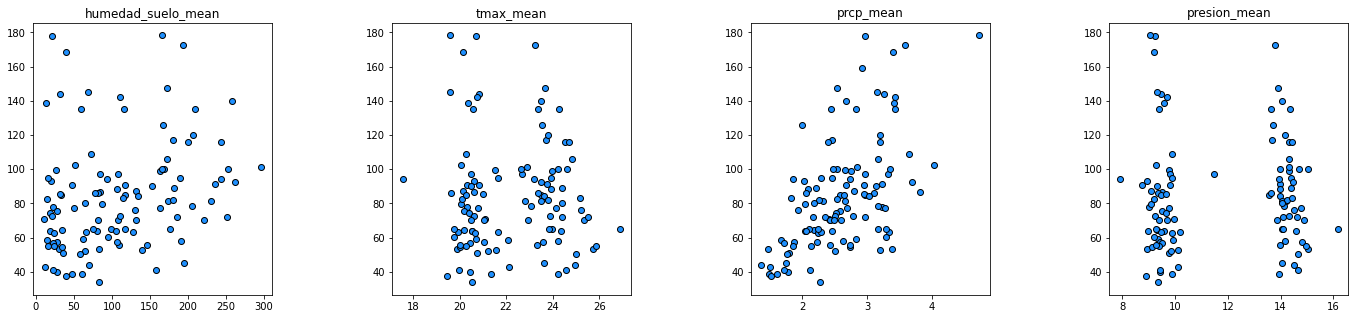

In [181]:
fig = plt.figure(figsize=(30,20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

i = 1
for feature in features_columns:
    ax = fig.add_subplot(3, 5, i)
    plt.scatter(X.loc[:, feature], y, facecolor='dodgerblue', edgecolor='k', label='datos')
    plt.title(feature)
    i += 1
plt.show()

In [215]:
# Lo que sigue es solo una prueba...

In [211]:
feature = 'presion_mean'
X_train_f = X_train.loc[:, feature].fillna(method='ffill')
X_test_f = X_test.loc[:, feature].fillna(method='ffill')
X_train_f = np.array(X_train_f).reshape(-1, 1)
X_test_f = np.array(X_test_f).reshape(-1, 1)
X_train_f.shape, X_test_f.shape

((91, 1), (23, 1))

In [212]:
model = LinearRegression()
model.fit(X_train_f, y_train)

LinearRegression()

In [214]:
y_train_pred = model.predict(X_train_f)
y_test_pred = model.predict(X_test_f)

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)
print(f'Train error: {train_error}')
print(f'Test error: {test_error}')

Train error: 981.0652894427927
Test error: 1242.5454310475234
